### Isolation Forest for Time-Series Anomaly Detection
Machine Temperature Failure

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle 

#### Data preprocessing

In [69]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
...,...,...
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [70]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal

# Access the lists
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)
#Change according to ds: [0] = machine_temperature, [1] = twitter_volume , [2] = nyc_taxi
instances_of_anomaly_machine = lists[0]        

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly_machine: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

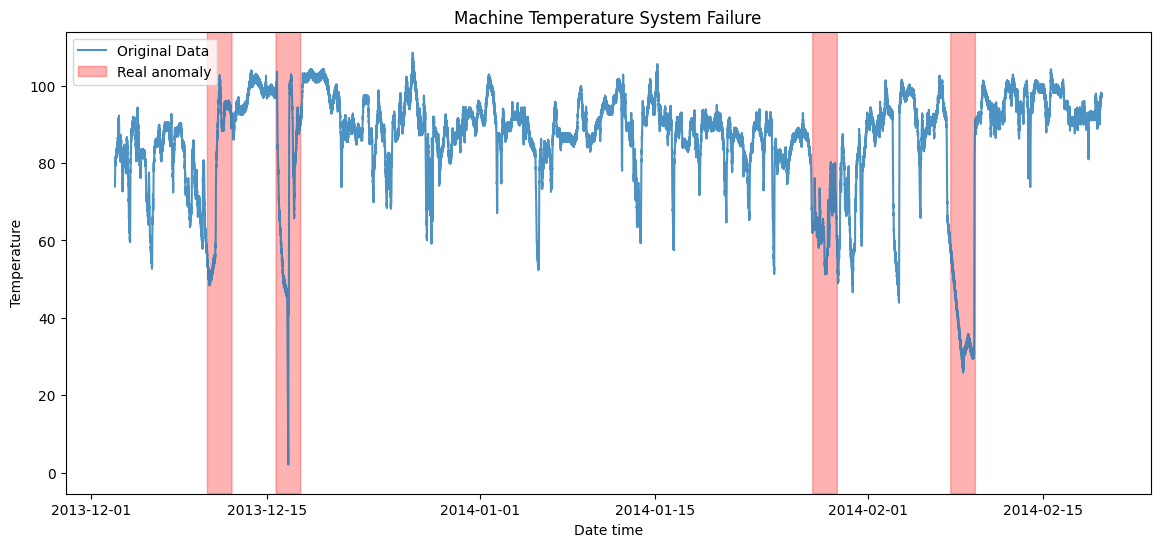

In [71]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], label='Original Data', alpha=0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
60% training, 20% validation and 20% testing

In [72]:
data_train = data[0:int(len(data)*0.6)]
data_val = data[int(len(data)*0.6):int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [73]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [74]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes) 
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val , autocorr_lag1]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [75]:
window_size = 288  # 1 day
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

In [76]:
(X_train_features.shape, X_val_features.shape, X_test_features.shape)

((13330, 149), (4252, 149), (4252, 149))

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [77]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.08327825512227363)

In [78]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [79]:
# Threshold for classifying instances as anomalies
# Bottom 1% of scores, since output of decision_function is between [-1, 1] with -1 being the most anomalous
threshold = np.percentile(anomaly_scores, 1)
print(threshold)

-0.08957966611056235


In [80]:
# Compute the anomaly scores for the test set
test_scores = model.decision_function(X_test_features)

In [81]:
# Classify instances as normal (0) or anomalous (1)
val_predictions = np.where(anomaly_scores <= threshold, 1, 0)
test_predictions = np.where(test_scores <= threshold, 1, 0)

In [82]:
def assign_point_predictions(window_predictions, window_size):
    point_predictions = np.append(np.full((window_size-1)//2, window_predictions[0]), window_predictions)
    point_predictions = np.append(point_predictions, np.full((window_size-1)//2+1, window_predictions[-1]))
    return point_predictions

In [83]:
val_point_predictions = assign_point_predictions(val_predictions, window_size)
test_point_predictions = assign_point_predictions(test_predictions, window_size)

In [84]:
# Validation set output predictions
print("Predictions:", val_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, val_point_predictions)
conf_matrix = confusion_matrix(labels_val, val_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.8656091650143203
Confusion Matrix:
[[3929   43]
 [ 567    0]]


In [85]:
# Test set output predictions
print("Predictions:", test_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_test, test_point_predictions)
conf_matrix = confusion_matrix(labels_test, test_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.8770654329147389
Confusion Matrix:
[[3759  213]
 [ 345  222]]


In [86]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, test_point_predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3972
           1       0.51      0.39      0.44       567

    accuracy                           0.88      4539
   macro avg       0.71      0.67      0.69      4539
weighted avg       0.87      0.88      0.87      4539



In [87]:
len(labels_test), len(test_point_predictions), len(test_predictions)

(4539, 4539, 4252)

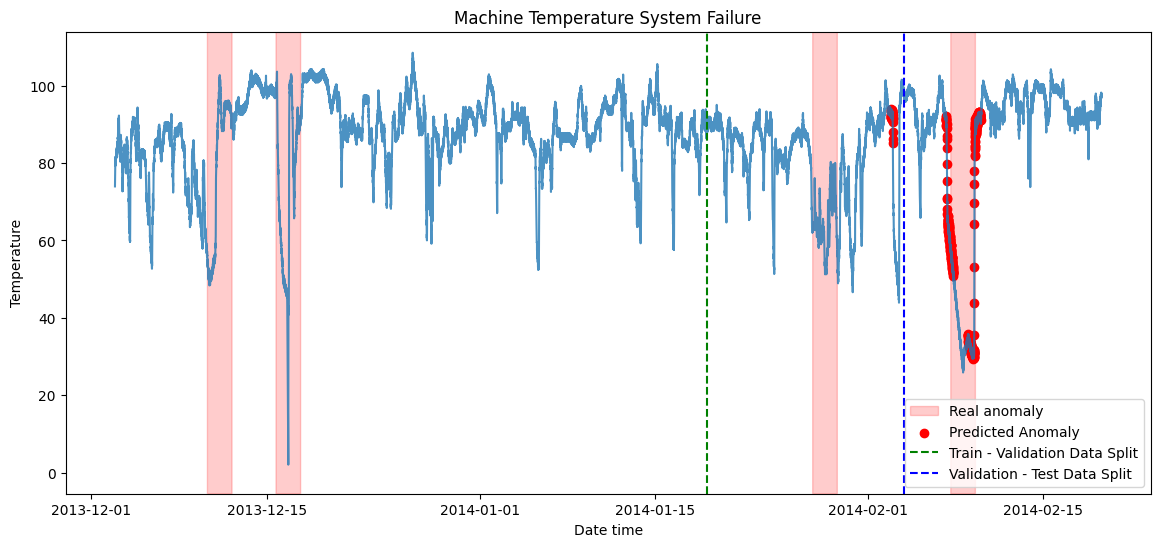

In [88]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], alpha= 0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.2, transform=ax.get_xaxis_transform(),label='Real anomaly')
ax.scatter(data_val['timestamp'][val_point_predictions == 1], data_val['value'][val_point_predictions == 1], color='red', label='Predicted Anomaly')
ax.scatter(data_test['timestamp'][test_point_predictions == 1], data_test['value'][test_point_predictions == 1], color='red')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
ax.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train - Validation Data Split')
ax.axvline(data_val['timestamp'].iloc[-1], color='blue', linestyle='--', label='Validation - Test Data Split')
plt.legend()
plt.show()